<a href="https://colab.research.google.com/github/obov/mnist/blob/main/1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Chapter 1 - 1 기본과제


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)

60000
torch.Size([1, 28, 28]) 5


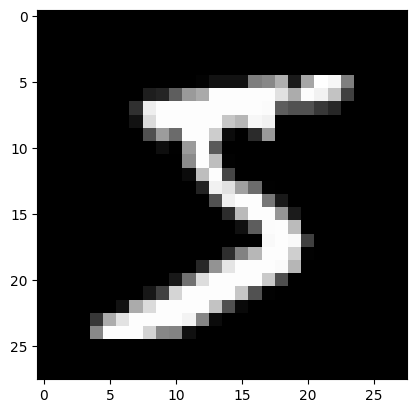

In [3]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap="gray")

In [4]:
from torch.utils.data import Subset


batch_size = 256
# 0부터 47999까지는 훈련용, 48000부터 59999까지는 검증용으로 설정
train_indices = list(range(48000))
val_indices = list(range(48000, 60000))

train_dataset = Subset(trainset, train_indices)
val_dataset = Subset(trainset, val_indices)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


In [6]:
from torch import nn

output_dim = 10


class Model(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, output_dim)

        self.act = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)  # 마지막 레이어에서는 활성화 함수 필요 없음

        return x


model = Model(28 * 28 * 1, 1024)

In [7]:
from torch.optim import SGD

if torch.backends.mps.is_available():
    device = torch.device("mps")
    model = model.to(device)
else:
    device = torch.device("cpu")
    model = model.to(device)
    print("MPS를 사용할 수 없습니다. CPU로 실행됩니다.")

lr = 0.001

optimizer = SGD(model.parameters(), lr=lr)

In [8]:
n_epochs = 100

import matplotlib.pyplot as plt

CEL = nn.CrossEntropyLoss()
train_accuracies = []
val_accuracies = []


def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to("mps"), labels.to("mps")

        preds = model(inputs)
        preds = torch.argmax(preds, dim=-1)

        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

    return acc / cnt


for epoch in range(n_epochs):
    model.train()  # 훈련 모드로 전환
    total_loss = 0.0

    # 훈련 루프
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to("mps"), labels.to("mps")

        preds = model(inputs)
        # loss = (preds[:, 0] - labels).pow(2).mean()
        # 손실 계산
        loss = CEL(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    train_accuracy = accuracy(model, train_loader)
    train_accuracies.append(train_accuracy)
    print(
        f"Epoch {epoch:3d} | Training Loss: {total_loss:.4f} | Accuracy : {train_accuracy:.2%}"
    )

    # 검증 루프
    model.eval()  # 검증 모드로 전환
    val_loss = 0.0
    with torch.no_grad():  # 검증할 때는 no_grad()를 사용하여 파라미터 업데이트를 하지 않음
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to("mps"), labels.to("mps")

            preds = model(inputs)
            # loss = (preds[:, 0] - labels).pow(2).mean()
            # 손실 계산
            loss = CEL(preds, labels)

            val_loss += loss.item()
    val_accuracy = accuracy(model, val_loader)
    val_accuracies.append(val_accuracy)
    print(
        f"Epoch {epoch:3d} | Validation Loss: {val_loss:.4f} | Accuracy : {val_accuracy:.2%}"
    )

Epoch   0 | Training Loss: 432.3624 | Accuracy : 14.51%
Epoch   0 | Validation Loss: 107.7676 | Accuracy : 14.06%
Epoch   1 | Training Loss: 429.9098 | Accuracy : 19.95%
Epoch   1 | Validation Loss: 107.1410 | Accuracy : 20.06%
Epoch   2 | Training Loss: 427.4341 | Accuracy : 26.68%
Epoch   2 | Validation Loss: 106.5011 | Accuracy : 27.20%
Epoch   3 | Training Loss: 424.8787 | Accuracy : 35.19%
Epoch   3 | Validation Loss: 105.8350 | Accuracy : 36.28%
Epoch   4 | Training Loss: 422.1937 | Accuracy : 46.05%
Epoch   4 | Validation Loss: 105.1298 | Accuracy : 47.69%
Epoch   5 | Training Loss: 419.3332 | Accuracy : 53.13%
Epoch   5 | Validation Loss: 104.3730 | Accuracy : 55.12%
Epoch   6 | Training Loss: 416.2477 | Accuracy : 57.59%
Epoch   6 | Validation Loss: 103.5510 | Accuracy : 59.88%
Epoch   7 | Training Loss: 412.8713 | Accuracy : 60.62%
Epoch   7 | Validation Loss: 102.6497 | Accuracy : 62.95%
Epoch   8 | Training Loss: 409.1515 | Accuracy : 62.79%
Epoch   8 | Validation Loss: 101

In [9]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to("mps")

print(model(x))
print(trainset[idx][1])

tensor([[ 1.6788, -3.7077,  0.3761,  4.4006, -5.5267,  3.9641, -2.2460, -0.4662,
          1.4256, -1.2418]], device='mps:0', grad_fn=<LinearBackward0>)
5


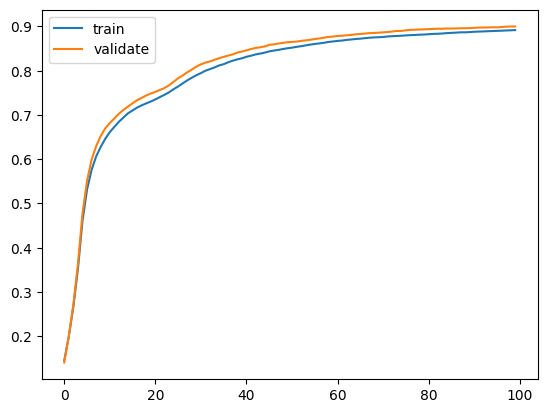

In [10]:
import numpy as np


def plot_acc(train_accs, test_accs, label1="train", label2="validate"):
    x = np.arange(len(train_accs))

    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.legend()
    plt.show()


plot_acc(train_accuracies, val_accuracies)